In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import astropy
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, get_body
import astropy.units as u
from augerscalerpy.scaler_cleaning import scaler_clean, plot_data
from augerscalerpy.plot_config import configure_plots
from augerscalerpy.scaler_fft import scalerfft_period, scalerfft_frec

from IPython.display import Image

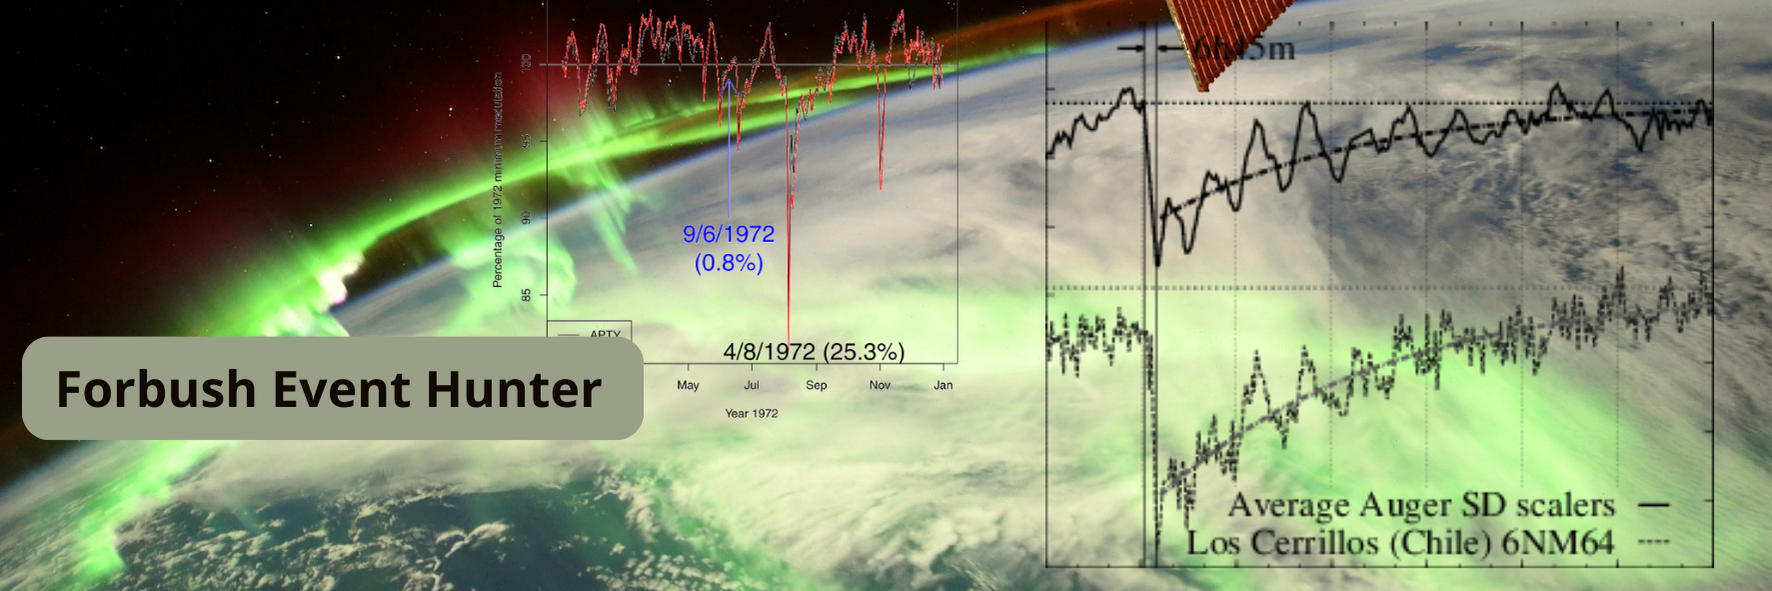

In [2]:
ruta_imagen_local = '/home/jennifer/Documentos/msc_tesis/P4.png'

Image(filename=ruta_imagen_local)

In [3]:

scaler300s = pd.read_csv('scaler_datasets/auger_cleaned_300s.csv', parse_dates=True)
scaler300s = scaler300s.sort_values('date')

In [4]:
scaler300s['date'] = pd.to_datetime(scaler300s['date'])

In [5]:
#scaler300s.set_index('date',inplace=True)
scaler300s['counts/s'] = pd.to_numeric(scaler300s['counts/s'])
#scaler300s.reset_index('date',inpla)
scaler300s

date  counts/s
4086    2005-12-31 23:59:46   1604.31
4087    2006-01-01 00:04:46   1604.31
4088    2006-01-01 00:09:46   1604.69
4089    2006-01-01 00:14:46   1604.73
4090    2006-01-01 00:19:46   1602.57
...                     ...       ...
1527671 2021-09-30 18:34:46   1665.46
1527672 2021-09-30 18:39:46   1665.10
1527673 2021-09-30 18:44:46   1666.21
1527674 2021-09-30 18:49:46   1661.49
1527675 2021-09-30 18:54:46   1671.58

[1533055 rows x 2 columns]

### Filtro de frecuencia por suavizado

In [22]:

# Frecuencia de muestreo
sample_rate = 1 / 300  # Muestreo cada 300 segundos

# Periodo que deseas eliminar (1 día)
period_to_remove = 1  # En días

# Tamaño de la ventana del filtro de promedio móvil
window_size = int(period_to_remove * 24 * 3600 / 300)  # Convertir el período a segundos y luego al número de puntos de datos

# Aplicar el filtro de promedio móvil
filtered_signal = scaler300s['counts/s'].rolling(window=window_size, min_periods=1).mean()

############## VERIFICACIÓN DE NULOS  ##############
if filtered_signal.isnull().values.any():
        print("Hay valores NaN en el DataFrame después de suavizar, llenaremos con la media.")
        filtered_signal.fillna(filtered_signal.mean(), inplace=True)
        if filtered_signal.isnull().values.any():
            print("Aún hay valores NaN en el DataFrame después del llenado.")
        else:
            print("Listo!")
else:
    print("No hay valores NaN en el DataFrame después del rolling.")
############## VERIFICACIÓN DE NULOS  ##############

# Crear un nuevo DataFrame con la señal filtrada


No hay valores NaN en el DataFrame después del rolling.


In [41]:
# Tamaño de la ventana del filtro de promedio móvil
window_size = int(period_to_remove * 24 * 3600 / 300)  # Convertir el período a segundos y luego al número de puntos de datos

# Calcular el retraso
delay = window_size / 2  # En términos del número de puntos de datos
delay_in_seconds = delay * 300  # Convertir a segundos
delay_in_seconds

43200.0

In [7]:
type(filtered_signal)

pandas.core.series.Series

In [23]:
scaler_smooth = scaler300s.copy()
scaler_smooth['counts/s'] = filtered_signal
scaler_smooth= scaler_smooth.sort_values('date')

In [24]:

dates = scaler300s['date'].values
scaler = scaler300s['counts/s'].values
smooth = scaler_smooth['counts/s'].values

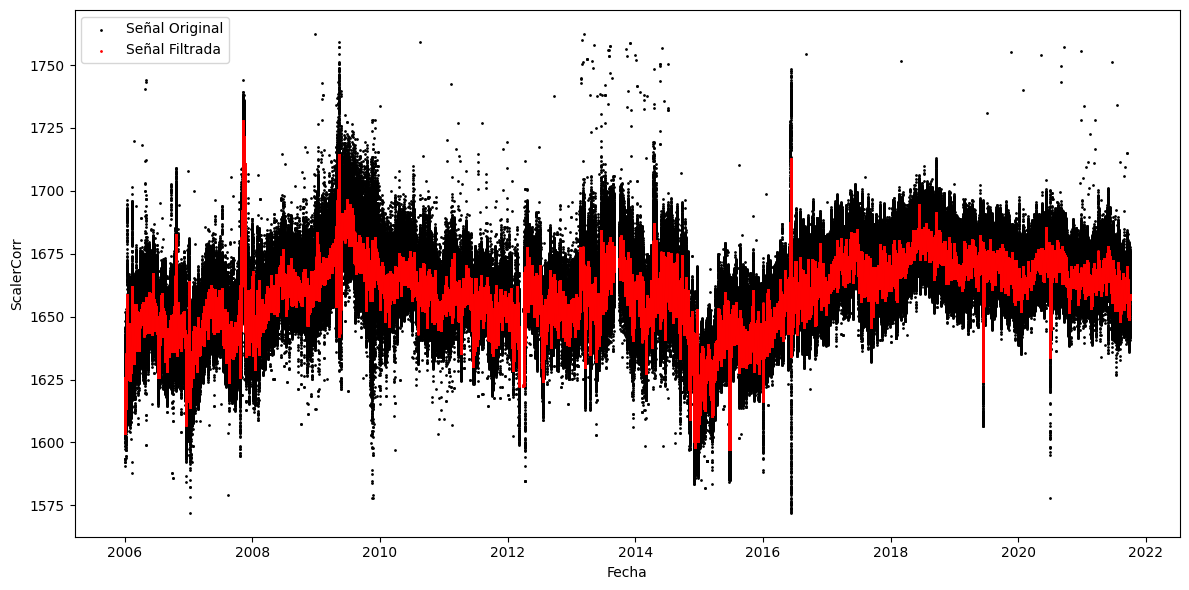

In [25]:

# Gráfico de la señal original y filtrada
plt.figure(figsize=(12, 6))
plt.scatter(dates, scaler, label='Señal Original', color='black', s=1)
plt.scatter(dates, smooth, label='Señal Filtrada', color='red',s=1)
plt.xlabel('Fecha')
plt.ylabel('ScalerCorr')
plt.legend()
#plt.gcf().autofmt_xdate()
plt.tight_layout()
# Mostrar el gráfico
#plt.savefig('auger_filter_1D.png')
plt.show()

#### Comparemos un Forbush con y sin filtrado:

In [26]:
forbush_auger = pd.read_csv('forbush_events/FD_type1_PIERRE_AUGER_2006-2021.csv')
forbush_auger = forbush_auger[['date', 'MagnM','Otype','Qs']]
#forbush_auger.set_index('date', inplace=True)

In [27]:
filtered_forbush_auger = forbush_auger.loc[forbush_auger['MagnM'] >= 6]
filtered_forbush_auger

date  MagnM  Otype   Qs
4    2006-12-14 14:14:00    9.6      1  5.0
49   2012-03-08 11:03:00   11.2      1  5.0
57   2012-07-14 18:09:00    7.6      1  4.0
104  2014-12-21 19:11:00    6.0      1  4.0
114  2015-06-22 18:33:00    9.1      1  4.0
139  2017-09-07 23:00:00    7.7      1  5.0

- scaler = scaler300s['counts/s'].values
- smooth = scaler_smooth['counts/s'].values

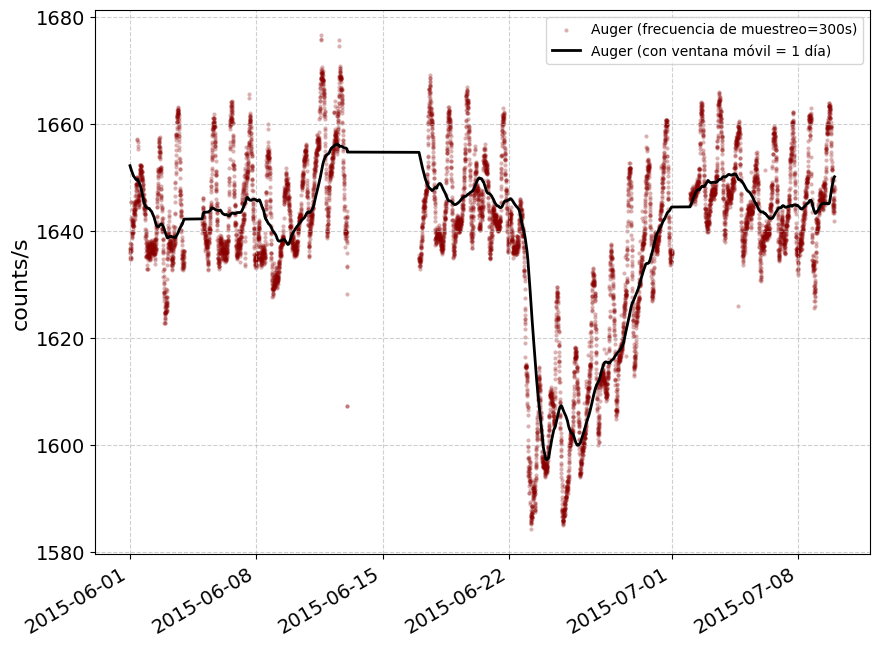

In [42]:
import matplotlib.pyplot as plt

# Filtrar las fechas para el rango que deseas comparar
start_date = "2015-06-01"
end_date = "2015-07-10"

filtered_scaler_smooth = scaler_smooth[(scaler300s['date'] >= start_date) & (scaler300s['date'] <= end_date)]
filtered_scaler300s = scaler300s[(scaler300s['date'] >= start_date) & (scaler300s['date'] <= end_date)]
#
filtered_scaler_smooth = filtered_scaler_smooth.sort_values('date')
filtered_scaler300s = filtered_scaler300s.sort_values('date')
# Graficar los datos en el mismo plot
plt.figure(figsize=(10, 8))


plt.scatter(filtered_scaler300s['date'], filtered_scaler300s['counts/s'], color='darkred', linewidth=2, label='Auger (frecuencia de muestreo=300s)', s=1, alpha=0.3)
plt.plot(filtered_scaler_smooth['date'], filtered_scaler_smooth['counts/s'], color='black', linewidth=2, label='Auger (con ventana móvil = 1 día)')

plt.xlabel('', fontsize=16)  # Nombre del eje horizontal con fuente más grande
plt.ylabel('counts/s', fontsize=16)  # Nombre del eje vertical con fuente más grande
#plt.title('Forbush observado por Pierre Auger M = 9.6 (2006-12-14)', fontsize=16)
plt.title('', fontsize=16)

plt.xticks(fontsize=14)  # Tamaño de fuente para los números del eje x
plt.yticks(fontsize=14)  # Tamaño de fuente para los números del eje y
plt.legend(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una grilla estética con líneas punteadas

plt.gcf().autofmt_xdate()

plt.legend()
#plt.savefig('forbush_filter_1D.png')
plt.show()


# COMIENZO DEL PARÉNTESIS

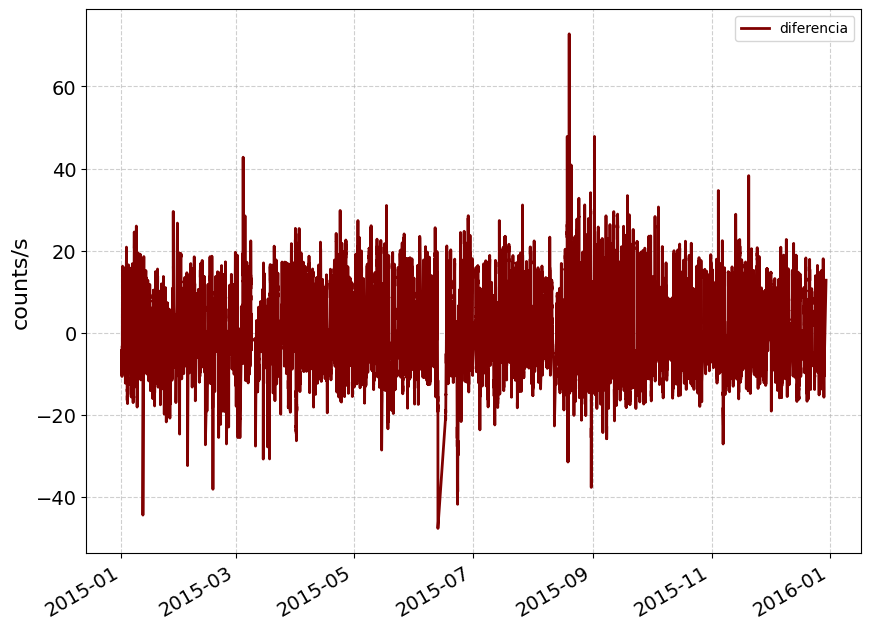

In [37]:
#filtered_scaler_smooth = scaler_smooth[(scaler300s['date'] >= start_date) & (scaler300s['date'] <= end_date)]
#filtered_scaler300s = scaler300s[(scaler300s['date'] >= start_date) & (scaler300s['date'] <= end_date)]
plt.figure(figsize=(10, 8))
plt.plot(filtered_scaler300s['date'], (filtered_scaler300s['counts/s']-filtered_scaler_smooth['counts/s']), color='maroon', linewidth=2, label='diferencia')


plt.xlabel('', fontsize=16)  # Nombre del eje horizontal con fuente más grande
plt.ylabel('counts/s', fontsize=16)  # Nombre del eje vertical con fuente más grande
#plt.title('Forbush observado por Pierre Auger M = 9.6 (2006-12-14)', fontsize=16)
plt.title('', fontsize=16)

plt.xticks(fontsize=14)  # Tamaño de fuente para los números del eje x
plt.yticks(fontsize=14)  # Tamaño de fuente para los números del eje y

plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una grilla estética con líneas punteadas

plt.gcf().autofmt_xdate()

#plt.savefig('forbush_filter_1D_DIFERENCIA.png')

plt.legend()
plt.show()

/home/jennifer/Documentos/msc_tesis/scaler_for_solar_analysis/augerscalerpy/scaler_fft.py:76: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / frequencies  # Calculamos el período en segundos


Ingresa un valor de periodo (en días) o escribe 'fin' para detenerte:  1
Ingresa un valor de periodo (en días) o escribe 'fin' para detenerte:  0.8
Ingresa un valor de periodo (en días) o escribe 'fin' para detenerte:  fin


Valores ingresados: [1.0, 0.8]


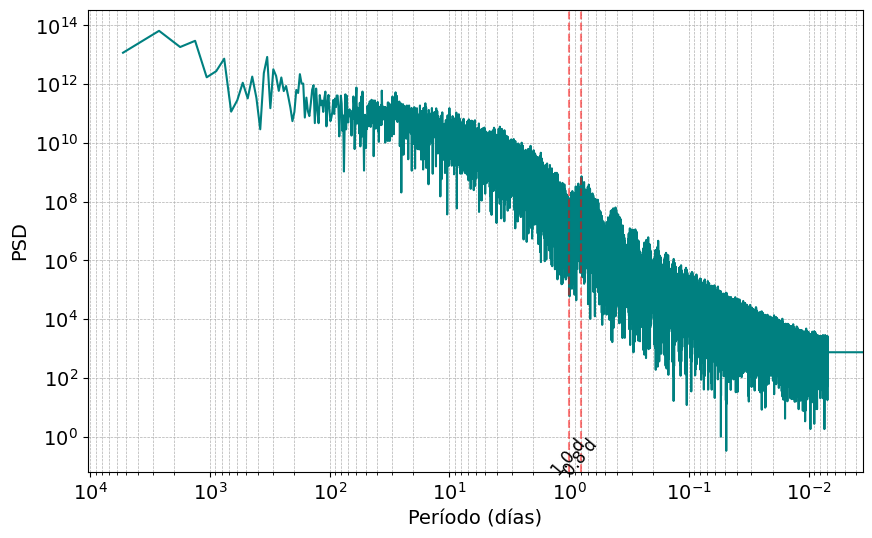

In [40]:
from augerscalerpy.scaler_fft import scalerfft_period, scalerfft_frec
x, y = scalerfft_period(300,scaler_smooth,1,'forbush_difference_FFT','counts/s')

In [28]:
y=(filtered_scaler300s['counts/s']-filtered_scaler_smooth['counts/s'])

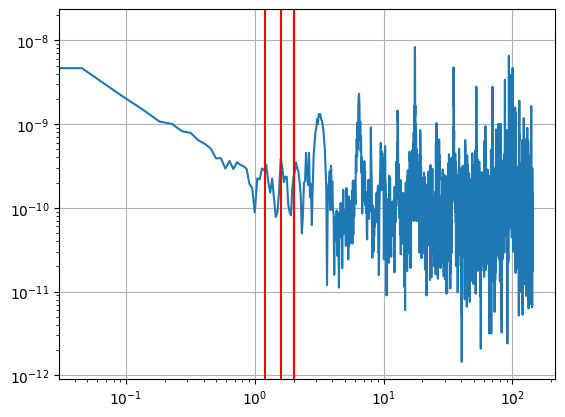

In [29]:
from scipy.fft import fft, fftfreq

import numpy as np

# Number of sample points

N = 6336

# sample spacing

T = 300
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)

yf = fft(y)

xf = fftfreq(N, T)[:N//2]

plt.loglog(xf*(3600*24), 2.0/N * np.abs(yf[0:N//2]))
plt.axvline(1.2, c='r')
plt.axvline(1.6, c='r')
plt.axvline(2.0, c='r')
plt.axvline(2.0, c='r')

plt.grid()

plt.show()

# FIN DEL PARÉNTESIS

In [43]:
## Función para  ver forbush y calcular porcentajes de dismunución:

import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd

def analyze_data(user_date, scaler300s, scaler_smooth):
    # Convertir la fecha del usuario a un objeto datetime
    user_date = datetime.strptime(user_date, "%Y-%m-%d")

    # Calcular las fechas de inicio y fin para el rango de 20 días antes y después de la fecha del usuario
    start_date = (user_date - timedelta(days=20)).strftime("%Y-%m-%d")
    end_date = (user_date + timedelta(days=20)).strftime("%Y-%m-%d")

    # Filtrar los datos para el rango de fechas
    filtered_scaler_smooth = scaler_smooth[(scaler_smooth['date'] >= start_date) & (scaler_smooth['date'] <= end_date)]
    filtered_scaler300s = scaler300s[(scaler300s['date'] >= start_date) & (scaler300s['date'] <= end_date)]

    # Ordenar los datos por fecha
    filtered_scaler_smooth = filtered_scaler_smooth.sort_values('date')
    filtered_scaler300s = filtered_scaler300s.sort_values('date')

    # Calcular el promedio, el mínimo y el porcentaje de diferencia
    average = filtered_scaler300s['counts/s'].mean()
    minimum = filtered_scaler300s['counts/s'].min()
    percent_difference = (average - minimum) / average * 100

    # Imprimir los resultados
    print("Promedio: ", average)
    print("Mínimo: ", minimum)
    print("Porcentaje de diferencia: ", percent_difference)

    # Graficar los datos
    plt.figure(figsize=(10, 8))
    plt.scatter(filtered_scaler300s['date'], filtered_scaler300s['counts/s'], color='darkred', linewidth=2, label='Auger (frecuencia de muestreo=300s)', s=1, alpha=0.3)
    plt.plot(filtered_scaler_smooth['date'], filtered_scaler_smooth['counts/s'], color='black', linewidth=2, label='Auger (con ventana móvil = 1 día)')
    plt.xlabel('', fontsize=16)
    plt.ylabel('counts/s', fontsize=16)
    plt.title('', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()


Promedio:  1641.2648701125986
Mínimo:  1612.62
Porcentaje de diferencia:  1.745292343376212


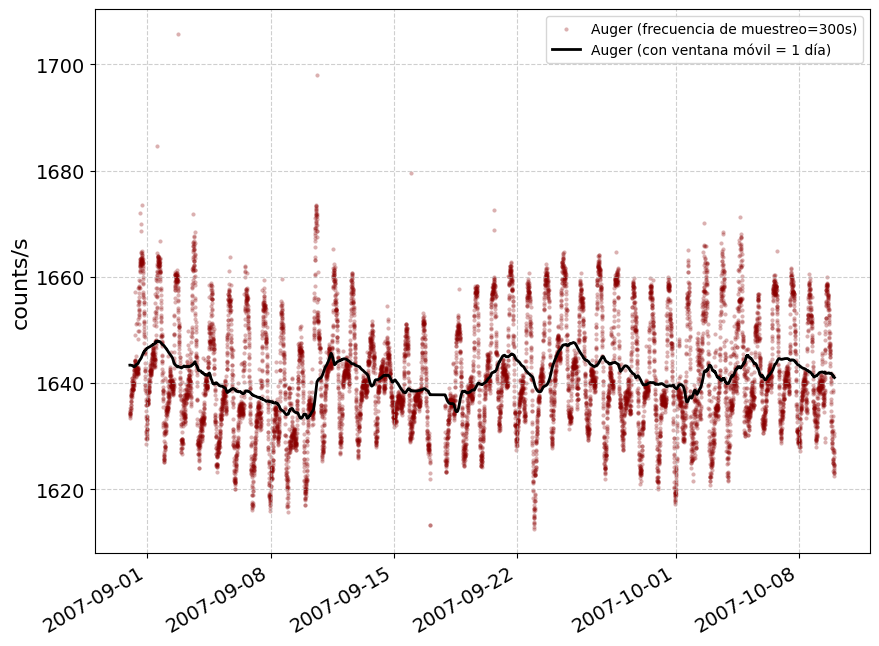

In [46]:

# Llamar a la función con la fecha del usuario
analyze_data("2007-09-20", scaler300s, scaler_smooth)


In [108]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd

def analyze_data(user_date, scaler300s, scaler_smooth, show_scaler300s=True):
    # Convertir la fecha del usuario a un objeto datetime
    user_date = datetime.strptime(user_date, "%Y-%m-%d")

    # Calcular las fechas de inicio y fin para el rango de 20 días antes y después de la fecha del usuario
    start_date = (user_date - timedelta(days=20)).strftime("%Y-%m-%d")
    end_date = (user_date + timedelta(days=20)).strftime("%Y-%m-%d")

    # Calcular las fechas de inicio y fin para el rango de 5 días antes y después de la fecha del usuario
    start_date_avg = (user_date - timedelta(days=0)).strftime("%Y-%m-%d")
    end_date_avg = (user_date + timedelta(days=6)).strftime("%Y-%m-%d")


    # Filtrar los datos para el rango de fechas
    filtered_scaler_smooth = scaler_smooth[(scaler_smooth['date'] >= start_date) & (scaler_smooth['date'] <= end_date)]
    filtered_scaler300s = scaler300s[(scaler300s['date'] >= start_date) & (scaler300s['date'] <= end_date)]

    # Filtrar los datos para el rango de fechas para calcular la media y el mínimo
    filtered_scaler_smooth_min = scaler_smooth[(scaler_smooth['date'] >= start_date_avg) & (scaler_smooth['date'] <= end_date_avg)]
    filtered_scaler_smooth_avg = scaler_smooth[(scaler_smooth['date'] <= start_date_avg) | (scaler_smooth['date'] > end_date_avg)]
    
    # Ordenar los datos por fecha
    filtered_scaler_smooth = filtered_scaler_smooth.sort_values('date')
    filtered_scaler300s = filtered_scaler300s.sort_values('date')

    # Calcular el promedio, el mínimo y el porcentaje de diferencia usando scaler_smooth
    average = filtered_scaler_smooth_avg['counts/s'].mean()
    minimum = filtered_scaler_smooth_min['counts/s'].min()
    percent_difference = (average - minimum) / average * 100

    # Imprimir los resultados
    print("Promedio: ", average)
    print("Mínimo: ", minimum)
    print("Porcentaje de diferencia: ", percent_difference)

    # Graficar los datos
    plt.figure(figsize=(10, 8))
    if show_scaler300s:
        plt.scatter(filtered_scaler300s['date'], filtered_scaler300s['counts/s'], color='darkred', linewidth=2, label='Auger (frecuencia de muestreo=300s)', s=1, alpha=0.3)
    plt.plot(filtered_scaler_smooth['date'], filtered_scaler_smooth['counts/s'], color='black', linewidth=2, label='Auger (con ventana móvil = 1 día)')
    # Trazar una línea vertical roja en la fecha del forbush
    plt.axvline(x=user_date, color='red', linestyle='--', alpha=0.6) #### AÑADIDO
    min_date = filtered_scaler_smooth_min[filtered_scaler_smooth_min['counts/s'] == minimum]['date']
    plt.scatter(min_date, minimum, color='red')
    plt.xlabel('', fontsize=16)
    plt.ylabel('counts/s', fontsize=16)
    plt.title('', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()




Promedio:  1659.1065900498122
Mínimo:  1610.668298611111
Porcentaje de diferencia:  2.9195406569536324


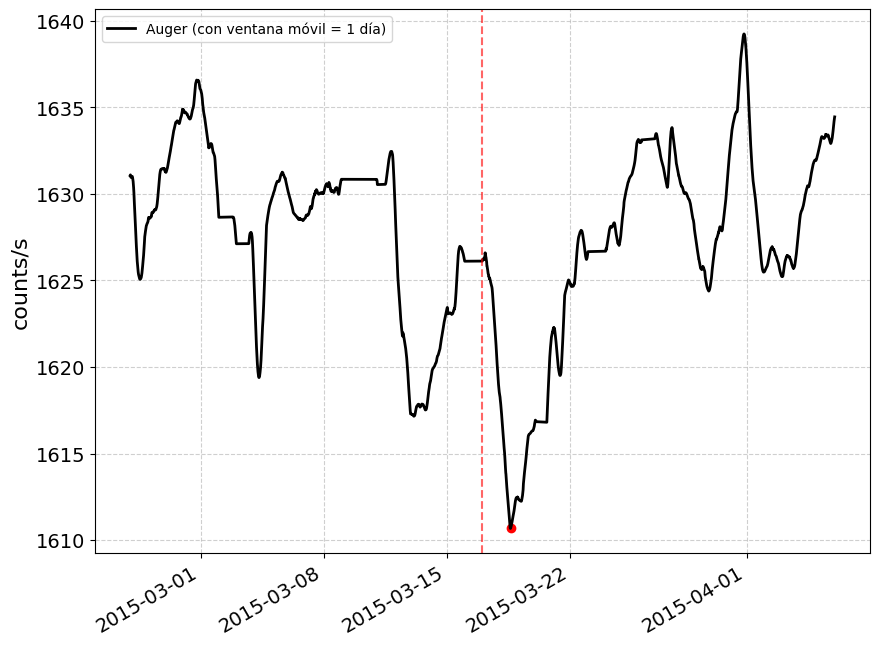

In [113]:
# Llamar a la función con la fecha del usuario
analyze_data("2015-03-17", scaler300s, scaler_smooth, show_scaler300s=False)

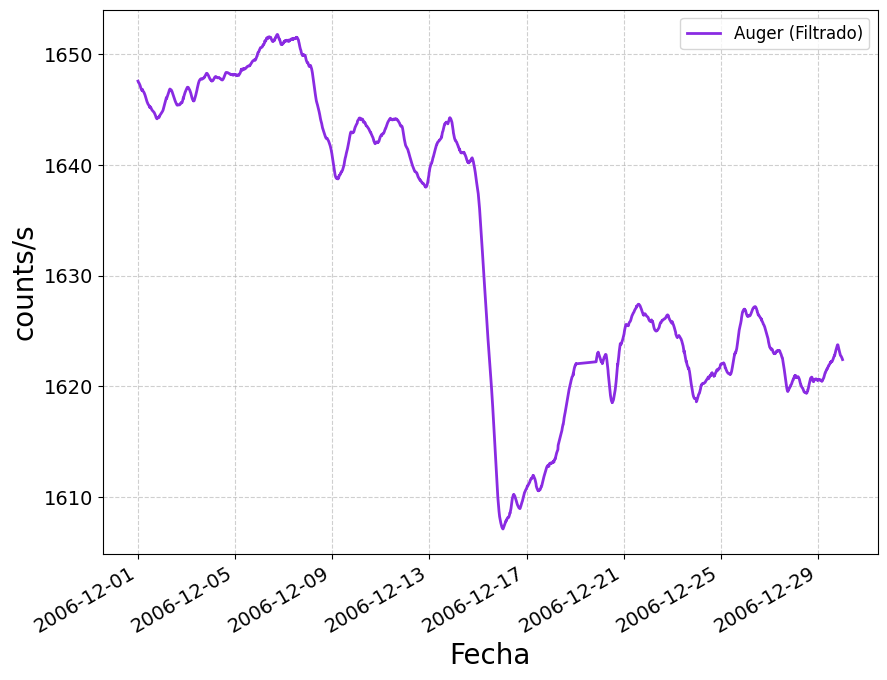

In [9]:
import matplotlib.pyplot as plt

# Supongamos que tienes los DataFrames 'filtered_scaler300s' y 'scaler300s'
# filtered_scaler300s = ...
# scaler300s = ...

# Filtrar las fechas para el rango que deseas comparar
start_date = "2006-12-01"
end_date = "2006-12-30"

filtered_scaler_smooth = scaler_smooth[(scaler_smooth['Date'] >= start_date) & (scaler_smooth['Date'] <= end_date)]
filtered_scaler300s = scaler300s[(scaler300s['Date'] >= start_date) & (scaler300s['Date'] <= end_date)]

# Graficar los datos en el mismo plot
plt.figure(figsize=(10, 8))

#plt.scatter(filtered_scaler300s['Date'], filtered_scaler300s['ScalerCorr'], color='darkred', linewidth=2, label='Auger (Original)', s=1, alpha=0.3)
plt.plot(filtered_scaler_smooth['Date'], filtered_scaler_smooth['ScalerCorr'], color='blueviolet', linewidth=2, label='Auger (Filtrado)')

plt.xlabel('Fecha', fontsize=20)  # Nombre del eje horizontal con fuente más grande
plt.ylabel('counts/s', fontsize=20)  # Nombre del eje vertical con fuente más grande

plt.xticks(fontsize=14)  # Tamaño de fuente para los números del eje x
plt.yticks(fontsize=14)  # Tamaño de fuente para los números del eje y

plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una grilla estética con líneas punteadas

plt.gcf().autofmt_xdate()

plt.legend()
plt.show()


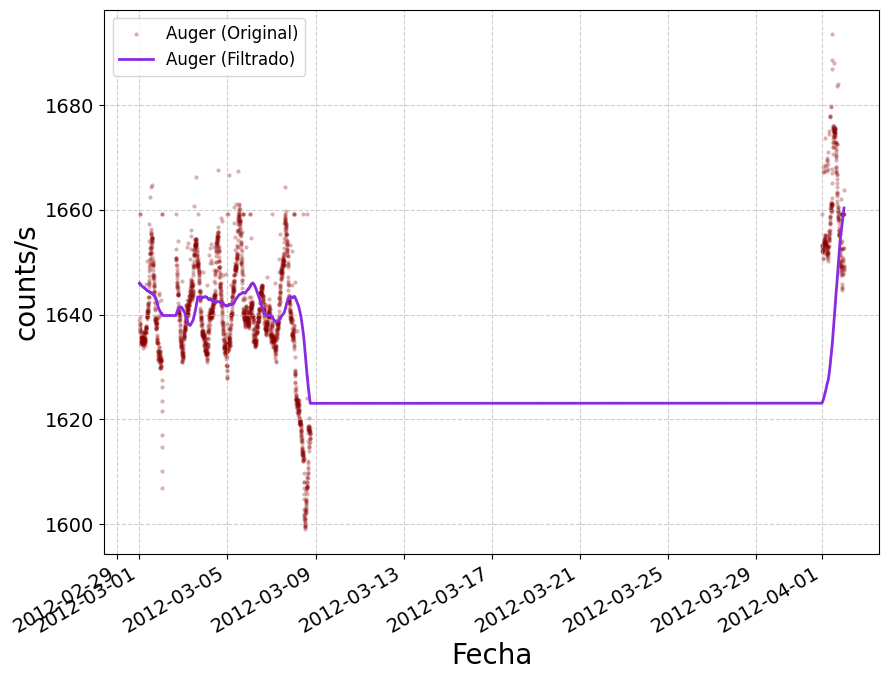

In [10]:
import matplotlib.pyplot as plt

# Supongamos que tienes los DataFrames 'filtered_scaler300s' y 'scaler300s'
# filtered_scaler300s = ...
# scaler300s = ...

# Filtrar las fechas para el rango que deseas comparar
start_date = "2012-03-01"
end_date = "2012-04-02"

filtered_scaler_smooth = scaler_smooth[(scaler_smooth['Date'] >= start_date) & (scaler_smooth['Date'] <= end_date)]
filtered_scaler300s = scaler300s[(scaler300s['Date'] >= start_date) & (scaler300s['Date'] <= end_date)]

# Graficar los datos en el mismo plot
plt.figure(figsize=(10, 8))

plt.scatter(filtered_scaler300s['Date'], filtered_scaler300s['ScalerCorr'], color='darkred', linewidth=2, label='Auger (Original)', s=1, alpha=0.3)
plt.plot(filtered_scaler_smooth['Date'], filtered_scaler_smooth['ScalerCorr'], color='blueviolet', linewidth=2, label='Auger (Filtrado)')

plt.xlabel('Fecha', fontsize=20)  # Nombre del eje horizontal con fuente más grande
plt.ylabel('counts/s', fontsize=20)  # Nombre del eje vertical con fuente más grande

plt.xticks(fontsize=14)  # Tamaño de fuente para los números del eje x
plt.yticks(fontsize=14)  # Tamaño de fuente para los números del eje y

plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una grilla estética con líneas punteadas

plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

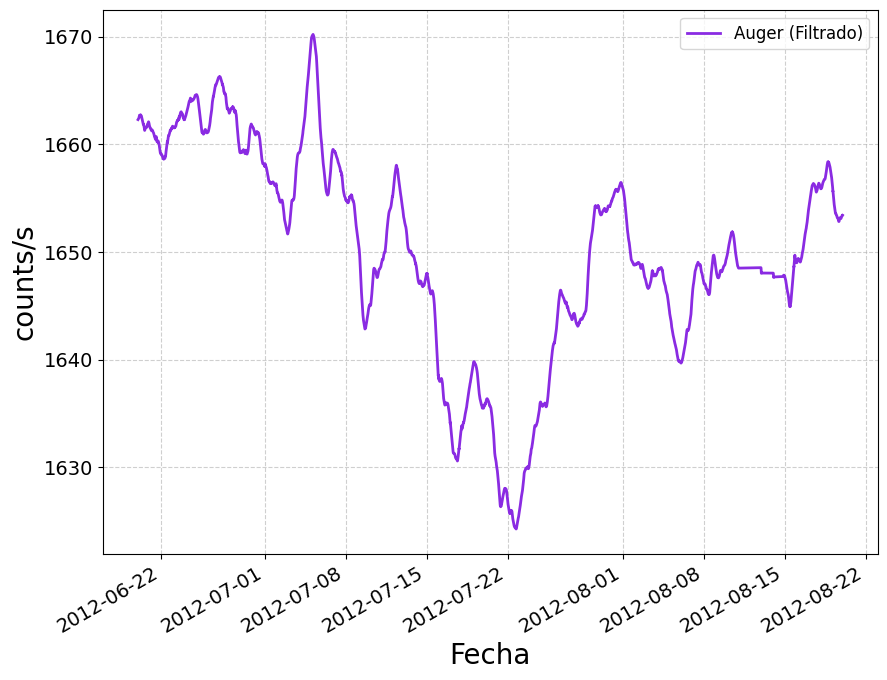

In [15]:
import matplotlib.pyplot as plt

# Supongamos que tienes los DataFrames 'filtered_scaler300s' y 'scaler300s'
# filtered_scaler300s = ...
# scaler300s = ...

# Filtrar las fechas para el rango que deseas comparar
start_date = "2012-06-20"
end_date = "2012-08-20"

filtered_scaler_smooth = scaler_smooth[(scaler_smooth['Date'] >= start_date) & (scaler_smooth['Date'] <= end_date)]
filtered_scaler300s = scaler300s[(scaler300s['Date'] >= start_date) & (scaler300s['Date'] <= end_date)]

# Graficar los datos en el mismo plot
plt.figure(figsize=(10, 8))

#plt.scatter(filtered_scaler300s['Date'], filtered_scaler300s['ScalerCorr'], color='darkred', linewidth=2, label='Auger (Original)', s=1, alpha=0.3)
plt.plot(filtered_scaler_smooth['Date'], filtered_scaler_smooth['ScalerCorr'], color='blueviolet', linewidth=2, label='Auger (Filtrado)')

plt.xlabel('Fecha', fontsize=20)  # Nombre del eje horizontal con fuente más grande
plt.ylabel('counts/s', fontsize=20)  # Nombre del eje vertical con fuente más grande

plt.xticks(fontsize=14)  # Tamaño de fuente para los números del eje x
plt.yticks(fontsize=14)  # Tamaño de fuente para los números del eje y

plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una grilla estética con líneas punteadas

plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

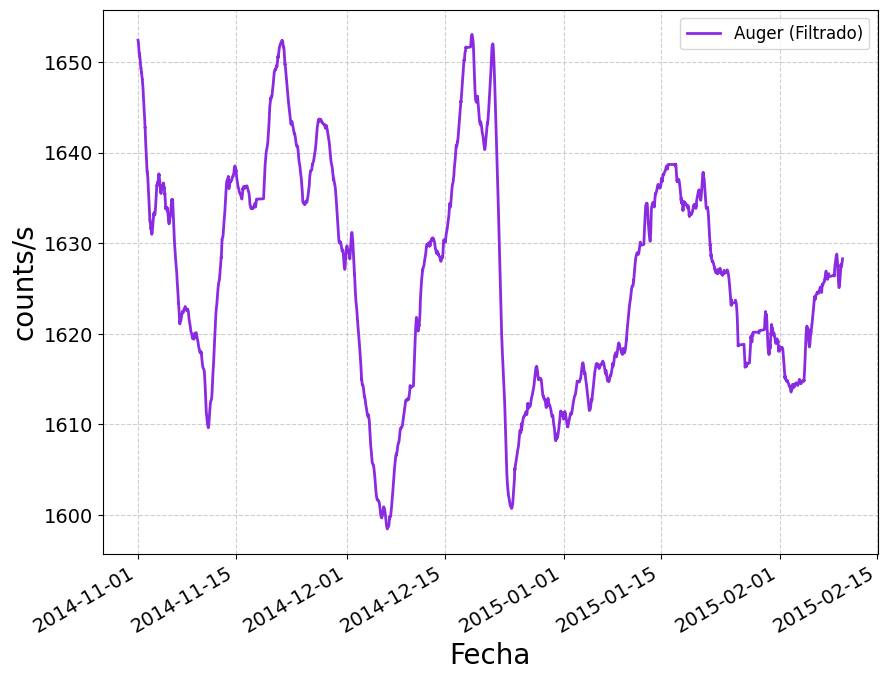

In [20]:
import matplotlib.pyplot as plt

# Supongamos que tienes los DataFrames 'filtered_scaler300s' y 'scaler300s'
# filtered_scaler300s = ...
# scaler300s = ...

# Filtrar las fechas para el rango que deseas comparar
start_date = "2014-11-01"
end_date = "2015-02-10"

filtered_scaler_smooth = scaler_smooth[(scaler_smooth['Date'] >= start_date) & (scaler_smooth['Date'] <= end_date)]
filtered_scaler300s = scaler300s[(scaler300s['Date'] >= start_date) & (scaler300s['Date'] <= end_date)]

# Graficar los datos en el mismo plot
plt.figure(figsize=(10, 8))

#plt.scatter(filtered_scaler300s['Date'], filtered_scaler300s['ScalerCorr'], color='darkred', linewidth=2, label='Auger (Original)', s=1, alpha=0.3)
plt.plot(filtered_scaler_smooth['Date'], filtered_scaler_smooth['ScalerCorr'], color='blueviolet', linewidth=2, label='Auger (Filtrado)')

plt.xlabel('Fecha', fontsize=20)  # Nombre del eje horizontal con fuente más grande
plt.ylabel('counts/s', fontsize=20)  # Nombre del eje vertical con fuente más grande

plt.xticks(fontsize=14)  # Tamaño de fuente para los números del eje x
plt.yticks(fontsize=14)  # Tamaño de fuente para los números del eje y

plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una grilla estética con líneas punteadas

plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

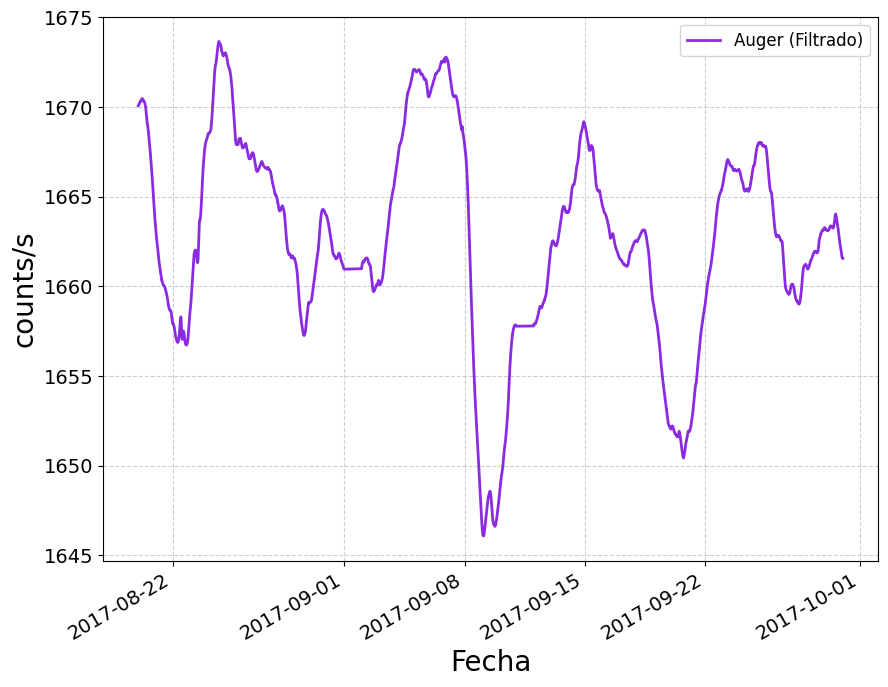

In [22]:
import matplotlib.pyplot as plt

# Supongamos que tienes los DataFrames 'filtered_scaler300s' y 'scaler300s'
# filtered_scaler300s = ...
# scaler300s = ...

# Filtrar las fechas para el rango que deseas comparar
start_date = "2017-08-20"
end_date = "2017-09-30"

filtered_scaler_smooth = scaler_smooth[(scaler_smooth['Date'] >= start_date) & (scaler_smooth['Date'] <= end_date)]
filtered_scaler300s = scaler300s[(scaler300s['Date'] >= start_date) & (scaler300s['Date'] <= end_date)]

# Graficar los datos en el mismo plot
plt.figure(figsize=(10, 8))

#plt.scatter(filtered_scaler300s['Date'], filtered_scaler300s['ScalerCorr'], color='darkred', linewidth=2, label='Auger (Original)', s=1, alpha=0.3)
plt.plot(filtered_scaler_smooth['Date'], filtered_scaler_smooth['ScalerCorr'], color='blueviolet', linewidth=2, label='Auger (Filtrado)')

plt.xlabel('Fecha', fontsize=20)  # Nombre del eje horizontal con fuente más grande
plt.ylabel('counts/s', fontsize=20)  # Nombre del eje vertical con fuente más grande

plt.xticks(fontsize=14)  # Tamaño de fuente para los números del eje x
plt.yticks(fontsize=14)  # Tamaño de fuente para los números del eje y

plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una grilla estética con líneas punteadas

plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

### ¿Cómo lucen los Forbush con magnitudes entre 0 y 1?

In [13]:
filtered_forbush_01 = forbush_auger.loc[forbush_auger['MagnM'] <= 1]
filtered_forbush_01

date  MagnM  Otype   Qs
1    2006-07-27 13:53:00    1.0      1  4.0
2    2006-08-07 00:35:00    0.9      1  4.0
5    2006-12-16 17:55:00    0.8      1  4.0
6    2006-12-18 10:14:00    0.9      1  4.0
9    2007-10-25 11:35:00    0.9      1  4.0
11   2008-01-31 11:23:00    0.6      1  4.0
12   2008-04-30 15:57:00    1.0      1  4.0
14   2008-09-30 12:34:00    1.0      1  4.0
15   2008-11-15 16:25:00    0.7      1  4.0
18   2009-03-03 06:02:00    0.4      1  4.0
19   2009-04-24 00:53:00    0.7      1  4.0
20   2009-05-28 05:19:00    0.9      1  4.0
21   2009-06-20 04:51:00    0.5      1  4.0
22   2009-08-07 15:55:00    0.7      1  4.0
23   2009-09-03 15:52:00    0.7      1  4.0
24   2009-10-04 04:12:00    0.8      1  4.0
25   2009-12-05 06:51:00    0.9      1  4.0
30   2010-08-04 10:19:00    0.6      1  4.0
44   2011-11-12 05:59:00    0.8      1  5.0
50   2012-03-11 13:00:00    0.8      1  5.0
54   2012-05-21 19:37:00    0.8      1  4.0
61   2012-09-30 11:31:00    1.0      1  4.0
66   2013-01-19 17:32:00    0.8      1  4.0
73   2013-05-19 23:08:00    0.8      1  5.0
80   2013-08-20 22:28:00    0.8      1  4.0
87   2014-02-13 09:44:00    0.7      1  4.0
94   2014-05-29 09:30:00    0.7      1  4.0
96   2014-06-23 23:08:00    0.4      1  5.0
97   2014-07-03 00:42:00    0.4      1  4.0
110  2015-04-14 06:16:00    1.0      1  4.0
112  2015-06-21 16:44:00    0.9      1  4.0
119  2015-08-28 12:49:00    1.0      1  4.0
129  2016-04-02 14:31:00    1.0      1  4.0
132  2016-11-09 06:43:00    0.8      1  4.0
133  2017-01-26 08:15:00    0.8      1  4.0
134  2017-03-27 03:45:00    1.0      1  4.0
137  2017-08-31 05:38:00    1.0      1  4.0
140  2017-09-12 20:02:00    1.0      1  5.0
143  2017-11-27 14:42:00    1.0      1  4.0
147  2018-03-09 18:06:00    0.9      1  4.0

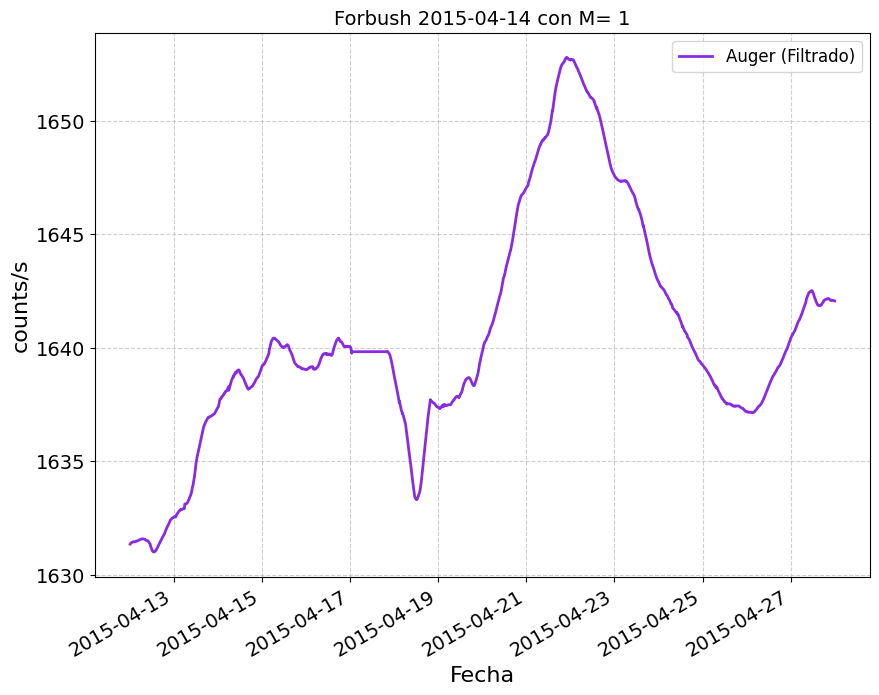

In [14]:
import matplotlib.pyplot as plt

# Supongamos que tienes los DataFrames 'filtered_scaler300s' y 'scaler300s'
# filtered_scaler300s = ...
# scaler300s = ...

# Filtrar las fechas para el rango que deseas comparar
start_date = "2015-04-12"
end_date = "2015-04-28"

filtered_scaler_smooth = scaler_smooth[(scaler_smooth['Date'] >= start_date) & (scaler_smooth['Date'] <= end_date)]
filtered_scaler300s = scaler300s[(scaler300s['Date'] >= start_date) & (scaler300s['Date'] <= end_date)]

# Graficar los datos en el mismo plot
plt.figure(figsize=(10, 8))

#plt.scatter(filtered_scaler300s['Date'], filtered_scaler300s['ScalerCorr'], color='darkred', linewidth=2, label='Auger (Original)', s=1, alpha=0.3)
plt.plot(filtered_scaler_smooth['Date'], filtered_scaler_smooth['ScalerCorr'], color='blueviolet', linewidth=2, label='Auger (Filtrado)')

plt.xlabel('Fecha', fontsize=16)  # Nombre del eje horizontal con fuente más grande
plt.ylabel('counts/s', fontsize=16)  # Nombre del eje vertical con fuente más grande
plt.title('Forbush 2015-04-14 con M= 1')
plt.xticks(fontsize=14)  # Tamaño de fuente para los números del eje x
plt.yticks(fontsize=14)  # Tamaño de fuente para los números del eje y

plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una grilla estética con líneas punteadas

plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

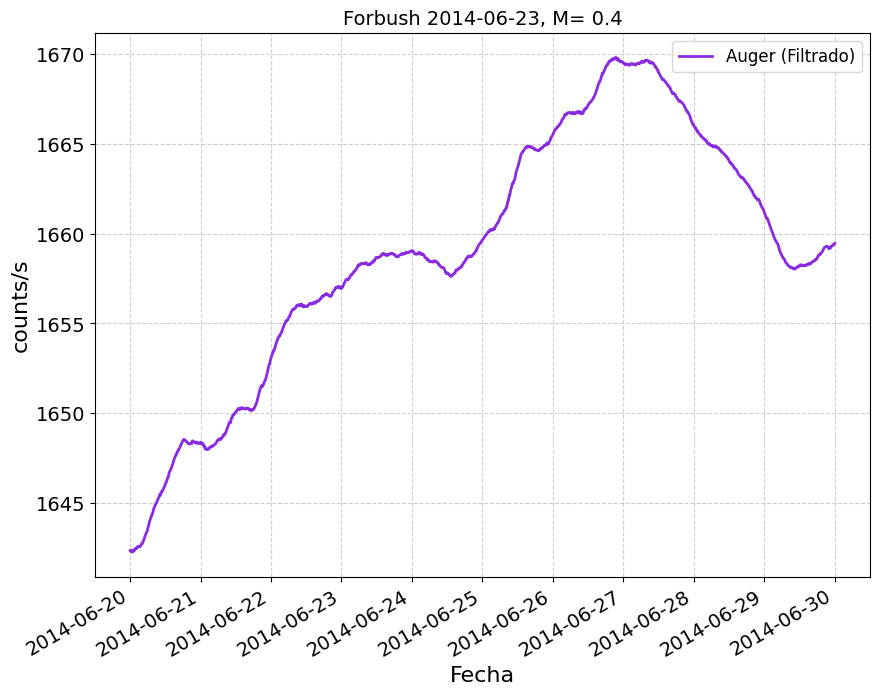

In [15]:
import matplotlib.pyplot as plt

# Supongamos que tienes los DataFrames 'filtered_scaler300s' y 'scaler300s'
# filtered_scaler300s = ...
# scaler300s = ...

# Filtrar las fechas para el rango que deseas comparar
start_date = "2014-06-20"
end_date = "2014-06-30"

filtered_scaler_smooth = scaler_smooth[(scaler_smooth['Date'] >= start_date) & (scaler_smooth['Date'] <= end_date)]
filtered_scaler300s = scaler300s[(scaler300s['Date'] >= start_date) & (scaler300s['Date'] <= end_date)]

# Graficar los datos en el mismo plot
plt.figure(figsize=(10, 8))

#plt.scatter(filtered_scaler300s['Date'], filtered_scaler300s['ScalerCorr'], color='darkred', linewidth=2, label='Auger (Original)', s=1, alpha=0.3)
plt.plot(filtered_scaler_smooth['Date'], filtered_scaler_smooth['ScalerCorr'], color='blueviolet', linewidth=2, label='Auger (Filtrado)')

plt.xlabel('Fecha', fontsize=16)  # Nombre del eje horizontal con fuente más grande
plt.ylabel('counts/s', fontsize=16)  # Nombre del eje vertical con fuente más grande
plt.title('Forbush 2014-06-23, M= 0.4')
plt.xticks(fontsize=14)  # Tamaño de fuente para los números del eje x
plt.yticks(fontsize=14)  # Tamaño de fuente para los números del eje y

plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una grilla estética con líneas punteadas

plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

In [16]:
filtered_forbush_01 = forbush_auger.loc[forbush_auger['MagnM'] <= 1]
filtered_forbush_01

date  MagnM  Otype   Qs
1    2006-07-27 13:53:00    1.0      1  4.0
2    2006-08-07 00:35:00    0.9      1  4.0
5    2006-12-16 17:55:00    0.8      1  4.0
6    2006-12-18 10:14:00    0.9      1  4.0
9    2007-10-25 11:35:00    0.9      1  4.0
11   2008-01-31 11:23:00    0.6      1  4.0
12   2008-04-30 15:57:00    1.0      1  4.0
14   2008-09-30 12:34:00    1.0      1  4.0
15   2008-11-15 16:25:00    0.7      1  4.0
18   2009-03-03 06:02:00    0.4      1  4.0
19   2009-04-24 00:53:00    0.7      1  4.0
20   2009-05-28 05:19:00    0.9      1  4.0
21   2009-06-20 04:51:00    0.5      1  4.0
22   2009-08-07 15:55:00    0.7      1  4.0
23   2009-09-03 15:52:00    0.7      1  4.0
24   2009-10-04 04:12:00    0.8      1  4.0
25   2009-12-05 06:51:00    0.9      1  4.0
30   2010-08-04 10:19:00    0.6      1  4.0
44   2011-11-12 05:59:00    0.8      1  5.0
50   2012-03-11 13:00:00    0.8      1  5.0
54   2012-05-21 19:37:00    0.8      1  4.0
61   2012-09-30 11:31:00    1.0      1  4.0
66   2013-01-19 17:32:00    0.8      1  4.0
73   2013-05-19 23:08:00    0.8      1  5.0
80   2013-08-20 22:28:00    0.8      1  4.0
87   2014-02-13 09:44:00    0.7      1  4.0
94   2014-05-29 09:30:00    0.7      1  4.0
96   2014-06-23 23:08:00    0.4      1  5.0
97   2014-07-03 00:42:00    0.4      1  4.0
110  2015-04-14 06:16:00    1.0      1  4.0
112  2015-06-21 16:44:00    0.9      1  4.0
119  2015-08-28 12:49:00    1.0      1  4.0
129  2016-04-02 14:31:00    1.0      1  4.0
132  2016-11-09 06:43:00    0.8      1  4.0
133  2017-01-26 08:15:00    0.8      1  4.0
134  2017-03-27 03:45:00    1.0      1  4.0
137  2017-08-31 05:38:00    1.0      1  4.0
140  2017-09-12 20:02:00    1.0      1  5.0
143  2017-11-27 14:42:00    1.0      1  4.0
147  2018-03-09 18:06:00    0.9      1  4.0

#### ¿Qué fracción de todos los forbush están entre los años 2012 y 2015 del total?

In [17]:
import pandas as pd

# Supongamos que tienes el DataFrame 'forbush_auger'
# forbush_auger = ...

# Convertir la columna 'Date' a tipo datetime
forbush_auger['date'] = pd.to_datetime(forbush_auger['date'])

# Definir el rango de años (2013 a 2015)
start_year = 2012
end_year = 2015

# Filtrar el DataFrame para incluir solo las filas en el rango de años
filtered_forbush_auger = forbush_auger[(forbush_auger['date'].dt.year >= start_year) & (forbush_auger['date'].dt.year <= end_year)]

# Calcular el porcentaje de datos en el rango de años con respecto al total
percentage = (len(filtered_forbush_auger) / len(forbush_auger)) * 100

print(f"Porcentaje de datos entre {start_year} y {end_year}: {percentage:.2f}%")


Porcentaje de datos entre 2012 y 2015: 55.41%


#### ¿Qué fracción de todos los forbush entre los años 2012 y 2015 tienen una magnitud mayor a 2?

In [18]:
import pandas as pd

# Supongamos que tienes el DataFrame 'forbush_auger'
# forbush_auger = ...

# Convertir la columna 'Date' a tipo datetime
forbush_auger['date'] = pd.to_datetime(forbush_auger['date'])

# Definir el rango de años (2013 a 2015)
start_year = 2012
end_year = 2015

# Filtrar el DataFrame para incluir solo las filas en el rango de años y con magnitud mayor a 2
filtered_forbush_auger = forbush_auger[(forbush_auger['date'].dt.year >= start_year) & (forbush_auger['date'].dt.year <= end_year) & (forbush_auger['MagnM'] > 2)]

# Calcular el porcentaje de datos en el rango de años y con magnitud mayor a 2 con respecto al total
percentage = (len(filtered_forbush_auger) / len(forbush_auger)) * 100

print(f"Porcentaje de datos entre {start_year} y {end_year} con MagnM > 2: {percentage:.2f}%")


Porcentaje de datos entre 2012 y 2015 con MagnM > 2: 28.38%


#### ¿Qué fracción de todos los forbush tienen una magnitud mayor a 2?

In [19]:
# Supongamos que tienes el DataFrame 'forbush_auger'
# forbush_auger = ...

# Filtrar el DataFrame para incluir solo las filas con magnitud mayor a 2
filtered_forbush_auger = forbush_auger[forbush_auger['MagnM'] > 2]

# Calcular el porcentaje de datos con magnitud mayor a 2 con respecto al total
percentage = (len(filtered_forbush_auger) / len(forbush_auger)) * 100

print(f"Porcentaje de datos con MagnM > 2: {percentage:.2f}%")


Porcentaje de datos con MagnM > 2: 39.86%


#### ¿Cómo lucen los Forbush de magnitud ~2?

In [22]:
import pandas as pd

# Convertir la columna 'Date' a tipo datetime
forbush_auger['date'] = pd.to_datetime(forbush_auger['date'])

# Definir el rango de años (2013 a 2015)
start_year = 2012
end_year = 2015

# Filtrar el DataFrame para incluir solo las filas en el rango de años y con magnitud mayor a 2
filtered_forbush_auger = forbush_auger[(forbush_auger['date'].dt.year >= start_year) & (forbush_auger['date'].dt.year <= end_year) & (forbush_auger['MagnM'] > 2)]


In [23]:
filtered_forbush_26 = forbush_auger.loc[(forbush_auger['MagnM'] >= 2) & (forbush_auger['MagnM'] <= 6)]
filtered_forbush_26

date  MagnM  Otype   Qs
0   2006-07-09 21:36:00    3.8      1  4.0
26  2010-04-05 08:26:00    3.1      1  4.0
28  2010-05-28 02:57:00    2.7      1  4.0
29  2010-08-03 17:41:00    3.7      1  4.0
34  2011-02-18 01:30:00    4.7      1  4.0
35  2011-03-10 06:45:00    3.0      1  4.0
36  2011-03-29 16:30:00    2.9      1  4.0
37  2011-04-01 16:48:00    2.2      1  4.0
39  2011-06-04 20:44:00    3.4      1  4.0
40  2011-08-05 17:51:00    4.8      1  4.0
41  2011-09-09 12:42:00    3.2      1  4.0
43  2011-09-26 12:35:00    5.1      1  4.0
45  2012-01-22 06:11:00    3.4      1  4.0
46  2012-01-24 15:03:00    3.2      1  4.0
47  2012-01-30 16:24:00    2.2      1  4.0
48  2012-03-07 04:20:00    3.8      1  4.0
51  2012-03-12 09:14:00    5.8      1  5.0
56  2012-06-16 20:20:00    4.0      1  4.0
58  2012-07-20 04:47:00    2.2      1  4.0
59  2012-07-21 16:05:00    2.7      1  4.0
60  2012-09-03 12:13:00    2.5      1  4.0
62  2012-09-30 23:05:00    2.1      1  4.0
64  2012-11-12 23:11:00    4.1      1  4.0
65  2012-11-23 21:51:00    3.6      1  4.0
69  2013-03-17 05:59:00    4.3      1  5.0
70  2013-04-13 22:54:00    4.4      1  5.0
71  2013-04-30 09:49:00    2.3      1  4.0
72  2013-05-18 01:10:00    2.1      1  4.0
75  2013-05-25 09:48:00    2.4      1  4.0
76  2013-05-31 16:18:00    2.2      1  4.0
77  2013-06-23 04:26:00    5.3      1  4.0
78  2013-06-27 14:38:00    2.8      1  4.0
79  2013-07-12 17:14:00    2.7      1  4.0
81  2013-08-24 00:03:00    2.6      1  4.0
82  2013-10-02 01:55:00    3.7      1  4.0
86  2014-01-09 20:08:00    2.3      1  5.0
88  2014-02-15 13:16:00    3.6      1  4.0
89  2014-02-20 03:18:00    2.8      1  4.0
90  2014-02-27 16:50:00    4.9      1  5.0
95  2014-06-07 16:52:00    3.9      1  4.0
100 2014-09-11 23:45:00    2.1      1  5.0
101 2014-09-12 15:53:00    5.9      1  5.0
103 2014-11-10 02:20:00    3.6      1  4.0
104 2014-12-21 19:11:00    6.0      1  4.0
105 2014-12-22 15:10:00    2.0      1  4.0
106 2014-12-23 11:14:00    2.7      1  4.0
108 2015-03-17 04:45:00    5.6      1  4.0
111 2015-05-06 01:42:00    2.6      1  4.0
116 2015-07-13 01:38:00    3.0      1  4.0
118 2015-08-15 08:28:00    2.0      1  4.0
123 2015-11-06 18:18:00    3.1      1  4.0
125 2015-12-19 16:16:00    3.1      1  4.0
126 2015-12-31 00:50:00    5.2      1  4.0
127 2016-01-18 21:57:00    2.0      1  5.0
130 2016-07-19 23:51:00    2.8      1  4.0
135 2017-05-27 15:34:00    2.9      1  4.0
136 2017-07-16 05:59:00    5.8      1  5.0

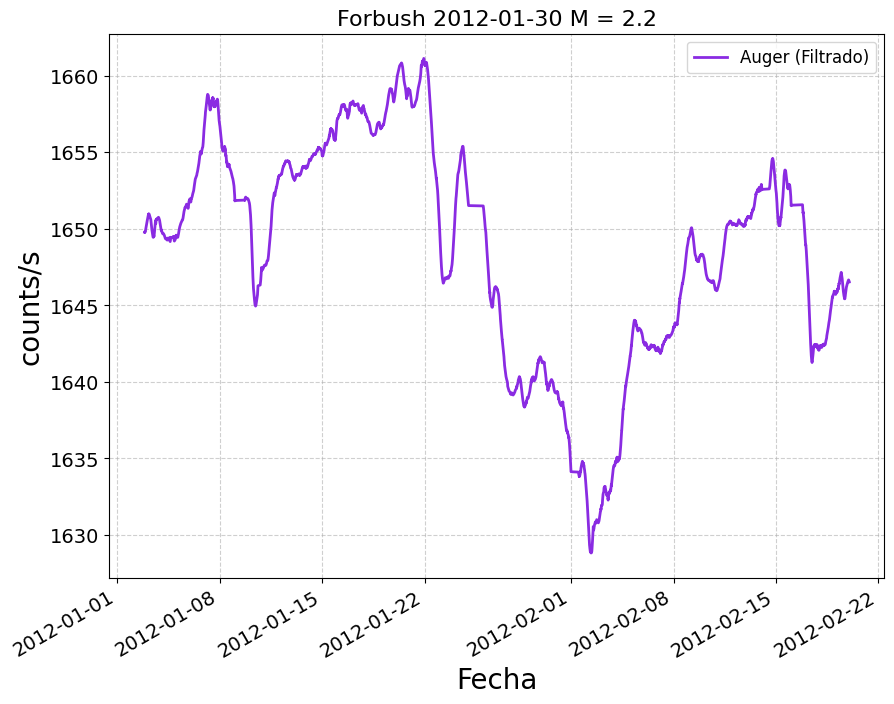

In [25]:
import matplotlib.pyplot as plt

# Supongamos que tienes los DataFrames 'filtered_scaler300s' y 'scaler300s'
# filtered_scaler300s = ...
# scaler300s = ...

# Filtrar las fechas para el rango que deseas comparar
start_date = "2012-01-01"
end_date = "2012-02-20"

filtered_scaler_smooth = scaler_smooth[(scaler_smooth['Date'] >= start_date) & (scaler_smooth['Date'] <= end_date)]
filtered_scaler300s = scaler300s[(scaler300s['Date'] >= start_date) & (scaler300s['Date'] <= end_date)]

# Graficar los datos en el mismo plot
plt.figure(figsize=(10, 8))

#plt.scatter(filtered_scaler300s['Date'], filtered_scaler300s['ScalerCorr'], color='darkred', linewidth=2, label='Auger (Original)', s=1, alpha=0.3)
plt.plot(filtered_scaler_smooth['Date'], filtered_scaler_smooth['ScalerCorr'], color='blueviolet', linewidth=2, label='Auger (Filtrado)')

plt.xlabel('Fecha', fontsize=20)  # Nombre del eje horizontal con fuente más grande
plt.ylabel('counts/s', fontsize=20)  # Nombre del eje vertical con fuente más grande
plt.title('Forbush 2012-01-30 M = 2.2', fontsize=16)

plt.xticks(fontsize=14)  # Tamaño de fuente para los números del eje x
plt.yticks(fontsize=14)  # Tamaño de fuente para los números del eje y

plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una grilla estética con líneas punteadas

plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

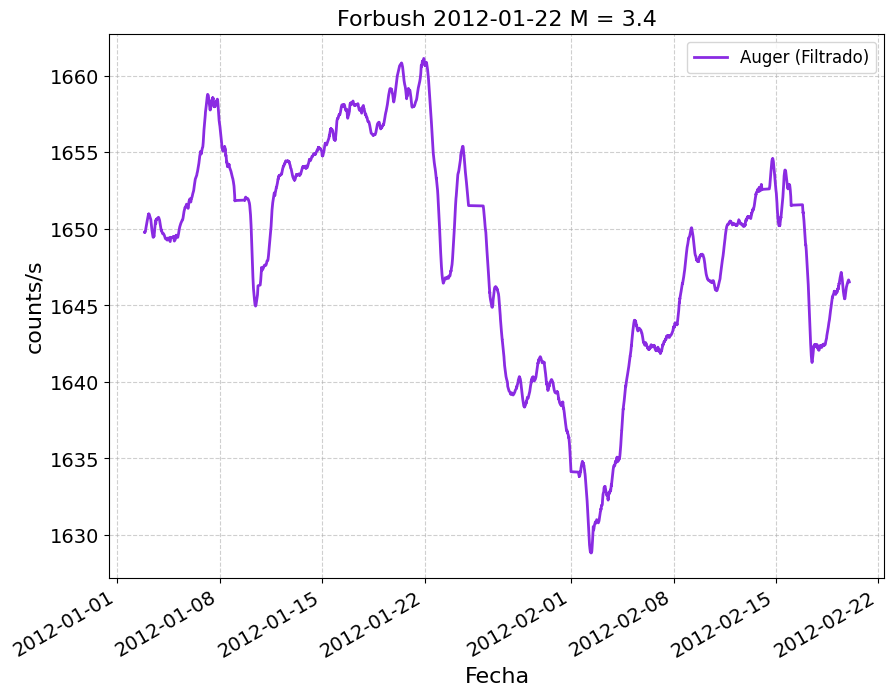

In [26]:
import matplotlib.pyplot as plt

# Supongamos que tienes los DataFrames 'filtered_scaler300s' y 'scaler300s'
# filtered_scaler300s = ...
# scaler300s = ...

# Filtrar las fechas para el rango que deseas comparar
start_date = "2012-01-01"
end_date = "2012-02-20"

filtered_scaler_smooth = scaler_smooth[(scaler_smooth['Date'] >= start_date) & (scaler_smooth['Date'] <= end_date)]
filtered_scaler300s = scaler300s[(scaler300s['Date'] >= start_date) & (scaler300s['Date'] <= end_date)]

# Graficar los datos en el mismo plot
plt.figure(figsize=(10, 8))

#plt.scatter(filtered_scaler300s['Date'], filtered_scaler300s['ScalerCorr'], color='darkred', linewidth=2, label='Auger (Original)', s=1, alpha=0.3)
plt.plot(filtered_scaler_smooth['Date'], filtered_scaler_smooth['ScalerCorr'], color='blueviolet', linewidth=2, label='Auger (Filtrado)')

plt.xlabel('Fecha', fontsize=16)  # Nombre del eje horizontal con fuente más grande
plt.ylabel('counts/s', fontsize=16)  # Nombre del eje vertical con fuente más grande
plt.title('Forbush 2012-01-22 M = 3.4', fontsize=16)

plt.xticks(fontsize=14)  # Tamaño de fuente para los números del eje x
plt.yticks(fontsize=14)  # Tamaño de fuente para los números del eje y

plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una grilla estética con líneas punteadas

plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

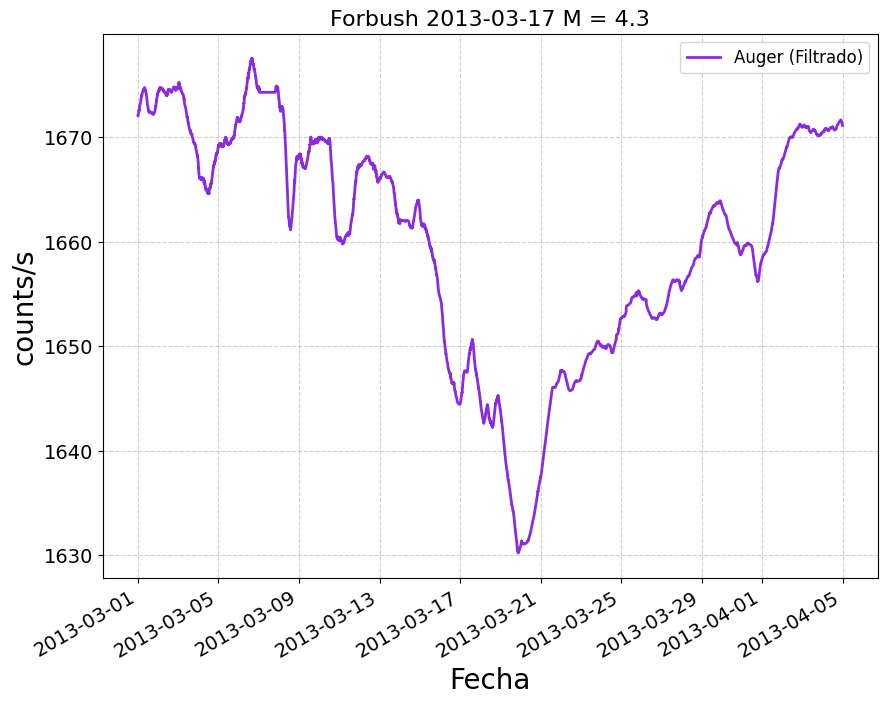

In [28]:
import matplotlib.pyplot as plt

# Supongamos que tienes los DataFrames 'filtered_scaler300s' y 'scaler300s'
# filtered_scaler300s = ...
# scaler300s = ...

# Filtrar las fechas para el rango que deseas comparar
start_date = "2013-03-01"
end_date = "2013-04-05"

filtered_scaler_smooth = scaler_smooth[(scaler_smooth['Date'] >= start_date) & (scaler_smooth['Date'] <= end_date)]
filtered_scaler300s = scaler300s[(scaler300s['Date'] >= start_date) & (scaler300s['Date'] <= end_date)]

# Graficar los datos en el mismo plot
plt.figure(figsize=(10, 8))

#plt.scatter(filtered_scaler300s['Date'], filtered_scaler300s['ScalerCorr'], color='darkred', linewidth=2, label='Auger (Original)', s=1, alpha=0.3)
plt.plot(filtered_scaler_smooth['Date'], filtered_scaler_smooth['ScalerCorr'], color='blueviolet', linewidth=2, label='Auger (Filtrado)')

plt.xlabel('Fecha', fontsize=20)  # Nombre del eje horizontal con fuente más grande
plt.ylabel('counts/s', fontsize=20)  # Nombre del eje vertical con fuente más grande
plt.title('Forbush 2013-03-17 M = 4.3', fontsize=16)

plt.xticks(fontsize=14)  # Tamaño de fuente para los números del eje x
plt.yticks(fontsize=14)  # Tamaño de fuente para los números del eje y

plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una grilla estética con líneas punteadas

plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

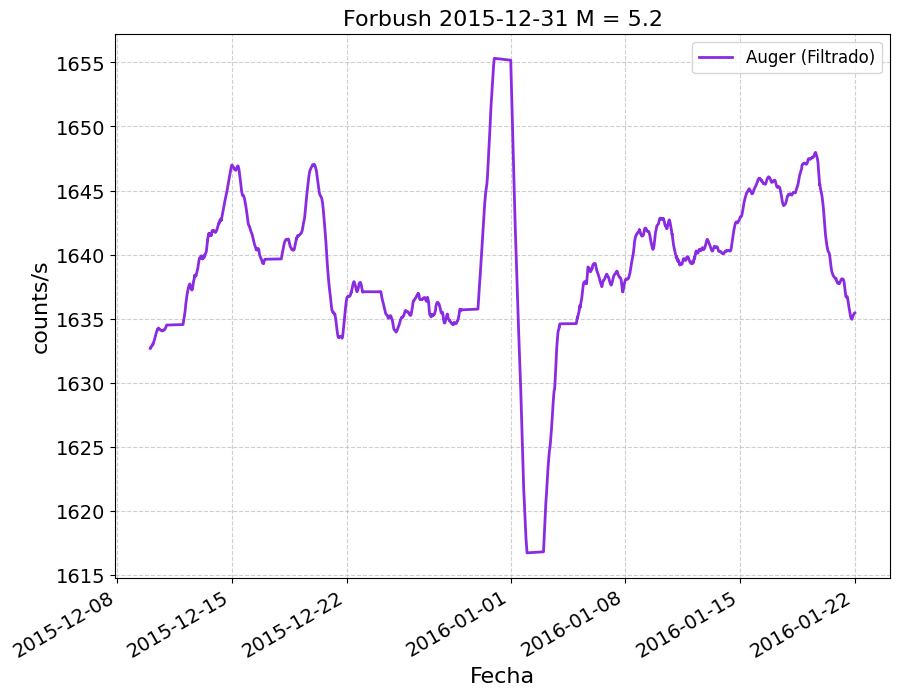

In [29]:
import matplotlib.pyplot as plt

# Supongamos que tienes los DataFrames 'filtered_scaler300s' y 'scaler300s'
# filtered_scaler300s = ...
# scaler300s = ...

# Filtrar las fechas para el rango que deseas comparar
start_date = "2015-12-10"
end_date = "2016-01-22"

filtered_scaler_smooth = scaler_smooth[(scaler_smooth['Date'] >= start_date) & (scaler_smooth['Date'] <= end_date)]
filtered_scaler300s = scaler300s[(scaler300s['Date'] >= start_date) & (scaler300s['Date'] <= end_date)]

# Graficar los datos en el mismo plot
plt.figure(figsize=(10, 8))

#plt.scatter(filtered_scaler300s['Date'], filtered_scaler300s['ScalerCorr'], color='darkred', linewidth=2, label='Auger (Original)', s=1, alpha=0.3)
plt.plot(filtered_scaler_smooth['Date'], filtered_scaler_smooth['ScalerCorr'], color='blueviolet', linewidth=2, label='Auger (Filtrado)')

plt.xlabel('Fecha', fontsize=16)  # Nombre del eje horizontal con fuente más grande
plt.ylabel('counts/s', fontsize=16)  # Nombre del eje vertical con fuente más grande
plt.title('Forbush 2015-12-31 M = 5.2', fontsize=16)

plt.xticks(fontsize=14)  # Tamaño de fuente para los números del eje x
plt.yticks(fontsize=14)  # Tamaño de fuente para los números del eje y

plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una grilla estética con líneas punteadas

plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

### Identificación de porcentajes de decrecimiento...

In [31]:
import pandas as pd

fall_events = []
start_date = None
end_date = None
percentage_threshold = 0.5  # Umbral del 5%

# Recorrer los datos
for index, row in scaler_smooth.iterrows():
    current_date = row['Date']
    current_value = row['ScalerCorr']
    
    # Calcular la diferencia porcentual con respecto al día anterior
    if start_date is not None:
        percentage_change = (current_value - prev_value) / prev_value
        if percentage_change <= -percentage_threshold:
            if start_date is None:
                start_date = current_date
            end_date = current_date
        else:
            # Verificar si se cumple el criterio de al menos 5 días
            if (end_date - start_date).days >= 6:
                fall_events.append((start_date, end_date))
            start_date = None
            end_date = None
    
    prev_value = current_value

# Imprimir los eventos de caídas súbitas
if fall_events:
    print("Eventos de caídas súbitas de al menos 5% en al menos 5 días:")
    for event in fall_events:
        print(f"Fecha de inicio: {event[0]}, Fecha de fin: {event[1]}")
else:
    print("No se encontraron eventos de caídas súbitas que cumplan con los criterios.")


No se encontraron eventos de caídas súbitas que cumplan con los criterios.
